# Import Library, Load Data

In [24]:
import tensorflow as tf
import numpy as np

In [4]:
import pandas as pd
from pandas import DataFrame, Series

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_init = pd.read_csv('datalab.csv')
df_init.head()

,date,americano,cafelatte,cafemoca,caramelmatk,icedamericano
0,2016-06-24,35.18592,23.27069,15.43382,26.34946,9.55617
1,2016-06-25,33.22670,23.75049,15.55377,25.54978,8.91643
2,2016-06-26,36.98520,26.30947,17.15313,27.38904,11.07556
3,2016-06-27,37.26509,24.39024,14.51419,25.26989,11.07556
4,2016-06-28,37.18512,23.23070,14.19432,24.99000,12.23510


# Model

In [7]:
# 1. RNN
# 2. LSTM

## Hyper parameters

In [8]:
#about X
timesteps = sequence_length = 7
data_dim = 5
data_lim = 5

#about Y and hidden size
hidden_size = 1
hidden_dim = 10
output_dim = 5


#about training
learning_rate = 0.05
epoch = 1

## Data Pre-Processing

In [9]:
df_xy = df_init.iloc[:,1:]
np_xy = df_xy.to_numpy()
batch_size = np_size = len(np_xy)
np_xy

array([[35.18592, 23.27069, 15.43382, 26.34946,  9.55617],
       [33.2267 , 23.75049, 15.55377, 25.54978,  8.91643],
       [36.9852 , 26.30947, 17.15313, 27.38904, 11.07556],
       ...,
       [30.46781, 18.03278, 14.2343 , 29.988  , 14.03438],
       [30.66773, 21.07157, 14.71411, 31.10755, 11.83526],
       [29.988  , 20.47181, 17.19312, 29.02838, 12.71491]])

In [10]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


scaled_np_xy = MinMaxScaler(np_xy)
#scaled_np_xy = StandardScaler(np_xy)

scaled_np_xy

array([[0.15440796, 0.40361459, 0.15528996, 0.21182279, 0.358736  ],
       [0.12884715, 0.42771057, 0.16040933, 0.17898207, 0.3289964 ],
       [0.17788213, 0.55622477, 0.22866872, 0.25451556, 0.42936788],
       ...,
       [0.09285349, 0.14056219, 0.10409541, 0.36124789, 0.56691455],
       [0.09546174, 0.29317287, 0.12457331, 0.40722481, 0.46468406],
       [0.08659369, 0.2630524 , 0.23037546, 0.32183886, 0.50557635]])

In [11]:
# train/test split
train_size = int(len(scaled_np_xy) * 0.7)
train_set = scaled_np_xy[0:train_size]
test_set = scaled_np_xy[train_size - sequence_length:]  
# Index from [train_size - seq_length] to utilize past sequence

In [12]:
# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, :]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, sequence_length)
testX, testY = build_dataset(test_set, sequence_length)

[[0.15440796 0.40361459 0.15528996 0.21182279 0.358736  ]
 [0.12884715 0.42771057 0.16040933 0.17898207 0.3289964 ]
 [0.17788213 0.55622477 0.22866872 0.25451556 0.42936788]
 [0.1815337  0.45983937 0.11604089 0.16748774 0.42936788]
 [0.18049038 0.40160626 0.1023891  0.15599341 0.48327142]
 [0.15910285 0.16265084 0.07508508 0.21839069 0.54646864]
 [0.20761611 0.20281146 0.1177472  0.23481104 0.46282551]] -> [0.09233177 0.26506023 0.13822511 0.24794725 0.28996266]
[[0.12884715 0.42771057 0.16040933 0.17898207 0.3289964 ]
 [0.17788213 0.55622477 0.22866872 0.25451556 0.42936788]
 [0.1815337  0.45983937 0.11604089 0.16748774 0.42936788]
 [0.18049038 0.40160626 0.1023891  0.15599341 0.48327142]
 [0.15910285 0.16265084 0.07508508 0.21839069 0.54646864]
 [0.20761611 0.20281146 0.1177472  0.23481104 0.46282551]
 [0.09233177 0.26506023 0.13822511 0.24794725 0.28996266]] -> [0.12415239 0.29919687 0.19965882 0.26108386 0.32713739]
[[0.17788213 0.55622477 0.22866872 0.25451556 0.42936788]
 [0.1815

 [0.03651551 0.17670665 0.08361751 0.00821018 0.13197009]] -> [0.06207619 0.19277131 0.13993185 0.03119843 0.07992556]
[[0.09650506 0.20281146 0.13822511 0.17898207 0.18587362]
 [0.0751174  0.1666665  0.14163816 0.1083742  0.15055745]
 [0.1194575  0.35140548 0.25767905 0.22495899 0.22304835]
 [0.07981229 0.17068266 0.04607518 0.09359613 0.10780661]
 [0.0239959  0.14658619 0.13139942 0.01806223 0.17843849]
 [0.03651551 0.17670665 0.08361751 0.00821018 0.13197009]
 [0.06207619 0.19277131 0.13993185 0.03119843 0.07992556]] -> [0.07668232 0.33534133 0.31569971 0.20197033 0.1189593 ]
[[0.0751174  0.1666665  0.14163816 0.1083742  0.15055745]
 [0.1194575  0.35140548 0.25767905 0.22495899 0.22304835]
 [0.07981229 0.17068266 0.04607518 0.09359613 0.10780661]
 [0.0239959  0.14658619 0.13139942 0.01806223 0.17843849]
 [0.03651551 0.17670665 0.08361751 0.00821018 0.13197009]
 [0.06207619 0.19277131 0.13993185 0.03119843 0.07992556]
 [0.07668232 0.33534133 0.31569971 0.20197033 0.1189593 ]] -> [0.1

 [0.05372988 0.36947796 0.26962453 0.33004904 0.0148698 ]] -> [0.04538342 0.30722869 0.32593845 0.28078797 0.02044591]
[[0.07563913 0.42369491 0.45221851 0.40229878 0.03717472]
 [0.12206574 0.37148579 0.35153572 0.46633835 0.05947965]
 [0.08398545 0.52008031 0.41296944 0.46141191 0.01301125]
 [0.10119981 0.51606415 0.43685997 0.59113291 0.04089229]
 [0.11006786 0.44176689 0.38566542 0.42692932 0.00929368]
 [0.05372988 0.36947796 0.26962453 0.33004904 0.0148698 ]
 [0.04538342 0.30722869 0.32593845 0.28078797 0.02044591]] -> [0.08085561 0.47188736 0.31740603 0.44334968 0.05018597]
[[0.12206574 0.37148579 0.35153572 0.46633835 0.05947965]
 [0.08398545 0.52008031 0.41296944 0.46141191 0.01301125]
 [0.10119981 0.51606415 0.43685997 0.59113291 0.04089229]
 [0.11006786 0.44176689 0.38566542 0.42692932 0.00929368]
 [0.05372988 0.36947796 0.26962453 0.33004904 0.0148698 ]
 [0.04538342 0.30722869 0.32593845 0.28078797 0.02044591]
 [0.08085561 0.47188736 0.31740603 0.44334968 0.05018597]] -> [0.1

 [0.03182062 0.02008031 0.13481205 0.11986853 0.02230493]] -> [0.05633812 0.25502008 0.49658694 0.24302122 0.04460986]
[[0.13406363 0.39156611 0.29863486 0.36945807 0.02416348]
 [0.16692757 0.34538149 0.31228666 0.51395714 0.06691432]
 [0.08294213 0.31927718 0.29010244 0.39244673 0.06505577]
 [0.08242053 0.1666665  0.20307145 0.22331671 0.02044591]
 [0.02503922 0.10642556 0.15528996 0.1018063  0.01858736]
 [0.03182062 0.02008031 0.13481205 0.11986853 0.02230493]
 [0.05633812 0.25502008 0.49658694 0.24302122 0.04460986]] -> [0.14241008 0.41967875 0.45563156 0.4220033  0.11710029]
[[0.16692757 0.34538149 0.31228666 0.51395714 0.06691432]
 [0.08294213 0.31927718 0.29010244 0.39244673 0.06505577]
 [0.08242053 0.1666665  0.20307145 0.22331671 0.02044591]
 [0.02503922 0.10642556 0.15528996 0.1018063  0.01858736]
 [0.03182062 0.02008031 0.13481205 0.11986853 0.02230493]
 [0.05633812 0.25502008 0.49658694 0.24302122 0.04460986]
 [0.14241008 0.41967875 0.45563156 0.4220033  0.11710029]] -> [0.1

 [0.19353158 0.09036141 0.10068235 0.21839069 0.4052044 ]] -> [0.19613982 0.20481929 0.17918092 0.22331671 0.36431211]
[[0.17423057 0.21084329 0.16382238 0.34154337 0.42565078]
 [0.2263954  0.33534133 0.15528996 0.28078797 0.55204475]
 [0.19979139 0.42369491 0.2406142  0.41215083 0.34758377]
 [0.24830465 0.26104407 0.2406142  0.40229878 0.32713739]
 [0.16797077 0.16867483 0.15358364 0.         0.45167281]
 [0.19353158 0.09036141 0.10068235 0.21839069 0.4052044 ]
 [0.19613982 0.20481929 0.17918092 0.22331671 0.36431211]] -> [0.24152325 0.35943781 0.254266   0.41215083 0.4052044 ]
[[0.2263954  0.33534133 0.15528996 0.28078797 0.55204475]
 [0.19979139 0.42369491 0.2406142  0.41215083 0.34758377]
 [0.24830465 0.26104407 0.2406142  0.40229878 0.32713739]
 [0.16797077 0.16867483 0.15358364 0.         0.45167281]
 [0.19353158 0.09036141 0.10068235 0.21839069 0.4052044 ]
 [0.19613982 0.20481929 0.17918092 0.22331671 0.36431211]
 [0.24152325 0.35943781 0.254266   0.41215083 0.4052044 ]] -> [0.2

 [0.08868033 0.44779088 0.43003429 0.42036101 0.03159861]] -> [0.09076685 0.47991968 0.45904419 0.50903111 0.04460986]
[[0.08659369 0.57228892 0.40614333 0.48440058 0.05762064]
 [0.12310907 0.37750979 0.41638207 0.52873563 0.02416348]
 [0.12050083 0.4357429  0.33105782 0.45484401 0.02602249]
 [0.0996349  0.52409647 0.29180875 0.32019699 0.02230493]
 [0.10119981 0.45582321 0.27815696 0.30706079 0.0148698 ]
 [0.08868033 0.44779088 0.43003429 0.42036101 0.03159861]
 [0.09076685 0.47991968 0.45904419 0.50903111 0.04460986]] -> [0.14501832 0.40562243 0.39419785 0.35467958 0.01301125]
[[0.12310907 0.37750979 0.41638207 0.52873563 0.02416348]
 [0.12050083 0.4357429  0.33105782 0.45484401 0.02602249]
 [0.0996349  0.52409647 0.29180875 0.32019699 0.02230493]
 [0.10119981 0.45582321 0.27815696 0.30706079 0.0148698 ]
 [0.08868033 0.44779088 0.43003429 0.42036101 0.03159861]
 [0.09076685 0.47991968 0.45904419 0.50903111 0.04460986]
 [0.14501832 0.40562243 0.39419785 0.35467958 0.01301125]] -> [0.1

 [0.29733964 0.27309256 0.12627963 0.40394065 0.37174724]] -> [0.20552947 0.28514055 0.18088723 0.51724129 0.42565078]
[[0.17683881 0.30722869 0.19283271 0.49096888 0.33829009]
 [0.13667187 0.14859452 0.20307145 0.33825922 0.24907084]
 [0.10693802 0.13654603 0.16894175 0.25615743 0.24349426]
 [0.13406363 0.18273115 0.28668938 0.41050896 0.27881043]
 [0.21752748 0.47389569 0.17064849 0.46141191 0.34944232]
 [0.29733964 0.27309256 0.12627963 0.40394065 0.37174724]
 [0.20552947 0.28514055 0.18088723 0.51724129 0.42565078]] -> [0.20761611 0.29919687 0.15358364 0.40229878 0.358736  ]
[[0.13667187 0.14859452 0.20307145 0.33825922 0.24907084]
 [0.10693802 0.13654603 0.16894175 0.25615743 0.24349426]
 [0.13406363 0.18273115 0.28668938 0.41050896 0.27881043]
 [0.21752748 0.47389569 0.17064849 0.46141191 0.34944232]
 [0.29733964 0.27309256 0.12627963 0.40394065 0.37174724]
 [0.20552947 0.28514055 0.18088723 0.51724129 0.42565078]
 [0.20761611 0.29919687 0.15358364 0.40229878 0.358736  ]] -> [0.1

 [0.15597288 0.31927718 0.22354935 0.29720832 0.09665438]] -> [0.10902454 0.49598383 0.23378852 0.40229878 0.16728626]
[[0.16379761 0.48795151 0.33959024 0.49096888 0.076208  ]
 [0.20031298 0.51204798 0.31228666 0.56814424 0.13197009]
 [0.18675018 0.72289127 0.30204792 0.58128085 0.09851293]
 [0.14293168 0.50200783 0.31569971 0.50410509 0.07434945]
 [0.13771519 0.48393585 0.25597274 0.34318566 0.1226764 ]
 [0.15597288 0.31927718 0.22354935 0.29720832 0.09665438]
 [0.10902454 0.49598383 0.23378852 0.40229878 0.16728626]] -> [0.09494001 0.57831342 0.40614333 0.49753678 0.13568765]
[[0.20031298 0.51204798 0.31228666 0.56814424 0.13197009]
 [0.18675018 0.72289127 0.30204792 0.58128085 0.09851293]
 [0.14293168 0.50200783 0.31569971 0.50410509 0.07434945]
 [0.13771519 0.48393585 0.25597274 0.34318566 0.1226764 ]
 [0.15597288 0.31927718 0.22354935 0.29720832 0.09665438]
 [0.10902454 0.49598383 0.23378852 0.40229878 0.16728626]
 [0.09494001 0.57831342 0.40614333 0.49753678 0.13568765]] -> [0.1

 [0.1262389  0.33935749 0.23890789 0.54844014 0.28996266]] -> [0.13197711 0.23293193 0.20648451 0.4482757  0.30669148]
[[0.06416284 0.45783104 0.33788393 0.48768473 0.18587362]
 [0.09076685 0.41566258 0.35494878 0.77011498 0.29368023]
 [0.13615027 0.44377522 0.29863486 0.65188831 0.33457252]
 [0.16849249 0.45381538 0.29692812 0.67980301 0.32713739]
 [0.15492956 0.36345397 0.25255968 0.59277478 0.282528  ]
 [0.1262389  0.33935749 0.23890789 0.54844014 0.28996266]
 [0.13197711 0.23293193 0.20648451 0.4482757  0.30669148]] -> [0.09285349 0.31726885 0.29180875 0.62068947 0.23048348]
[[0.09076685 0.41566258 0.35494878 0.77011498 0.29368023]
 [0.13615027 0.44377522 0.29863486 0.65188831 0.33457252]
 [0.16849249 0.45381538 0.29692812 0.67980301 0.32713739]
 [0.15492956 0.36345397 0.25255968 0.59277478 0.282528  ]
 [0.1262389  0.33935749 0.23890789 0.54844014 0.28996266]
 [0.13197711 0.23293193 0.20648451 0.4482757  0.30669148]
 [0.09285349 0.31726885 0.29180875 0.62068947 0.23048348]] -> [0.1

In [13]:
#build kind of coffe

#np_americano = trainX[:,1]

np.shape(trainX)
np.shape(trainY)
#np.shape(trainX[:,:,1])
#trainX[:,:,1]
#trainY[:,1]

(759, 5)

## RNN Model

In [14]:
X = tf.placeholder(tf.float32, [None, sequence_length, data_dim])
Y = tf.placeholder(tf.float32, [None, data_dim])

In [15]:
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, 
    state_is_tuple=True, 
    activation=tf.tanh)

outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, 5], 
    output_dim, 
    activation_fn=None)  # We use the last cell's output


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [17]:
# RMSE
targets = tf.placeholder(tf.float32, [None, 5])
predictions = tf.placeholder(tf.float32, [None, 5])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [18]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(500):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))
        
        
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))


[step: 0] loss: 317.4137268066406
[step: 1] loss: 200.8122100830078
[step: 2] loss: 111.22528076171875
[step: 3] loss: 114.74610900878906
[step: 4] loss: 97.96866607666016
[step: 5] loss: 84.8486099243164
[step: 6] loss: 81.10689544677734
[step: 7] loss: 76.118408203125
[step: 8] loss: 67.16473388671875
[step: 9] loss: 59.44321823120117
[step: 10] loss: 55.471214294433594
[step: 11] loss: 54.06998825073242
[step: 12] loss: 53.65282440185547
[step: 13] loss: 52.580448150634766
[step: 14] loss: 49.578041076660156
[step: 15] loss: 44.98758316040039
[step: 16] loss: 40.6833381652832
[step: 17] loss: 38.35214614868164
[step: 18] loss: 38.2535285949707
[step: 19] loss: 39.17865753173828
[step: 20] loss: 39.346649169921875
[step: 21] loss: 37.84680938720703
[step: 22] loss: 35.390281677246094
[step: 23] loss: 33.49874496459961
[step: 24] loss: 33.10124206542969
[step: 25] loss: 33.899391174316406
[step: 26] loss: 34.8209342956543
[step: 27] loss: 34.99492645263672
[step: 28] loss: 34.38648223

[step: 231] loss: 26.651182174682617
[step: 232] loss: 26.642295837402344
[step: 233] loss: 26.6334285736084
[step: 234] loss: 26.62458038330078
[step: 235] loss: 26.61573600769043
[step: 236] loss: 26.60693359375
[step: 237] loss: 26.598127365112305
[step: 238] loss: 26.589344024658203
[step: 239] loss: 26.580570220947266
[step: 240] loss: 26.57181739807129
[step: 241] loss: 26.56307601928711
[step: 242] loss: 26.55434226989746
[step: 243] loss: 26.545631408691406
[step: 244] loss: 26.536930084228516
[step: 245] loss: 26.528242111206055
[step: 246] loss: 26.519577026367188
[step: 247] loss: 26.51091957092285
[step: 248] loss: 26.502260208129883
[step: 249] loss: 26.493635177612305
[step: 250] loss: 26.485021591186523
[step: 251] loss: 26.47640037536621
[step: 252] loss: 26.467809677124023
[step: 253] loss: 26.459224700927734
[step: 254] loss: 26.450641632080078
[step: 255] loss: 26.44209098815918
[step: 256] loss: 26.433544158935547
[step: 257] loss: 26.42499351501465
[step: 258] loss

[step: 462] loss: 25.169225692749023
[step: 463] loss: 25.163190841674805
[step: 464] loss: 25.15713119506836
[step: 465] loss: 25.15106773376465
[step: 466] loss: 25.144981384277344
[step: 467] loss: 25.138912200927734
[step: 468] loss: 25.132810592651367
[step: 469] loss: 25.126707077026367
[step: 470] loss: 25.12059211730957
[step: 471] loss: 25.114458084106445
[step: 472] loss: 25.10832977294922
[step: 473] loss: 25.1021671295166
[step: 474] loss: 25.096012115478516
[step: 475] loss: 25.089845657348633
[step: 476] loss: 25.083654403686523
[step: 477] loss: 25.07746696472168
[step: 478] loss: 25.07126808166504
[step: 479] loss: 25.06504249572754
[step: 480] loss: 25.058818817138672
[step: 481] loss: 25.05257797241211
[step: 482] loss: 25.04633140563965
[step: 483] loss: 25.040061950683594
[step: 484] loss: 25.033790588378906
[step: 485] loss: 25.02750015258789
[step: 486] loss: 25.021207809448242
[step: 487] loss: 25.0148983001709
[step: 488] loss: 25.008607864379883
[step: 489] los

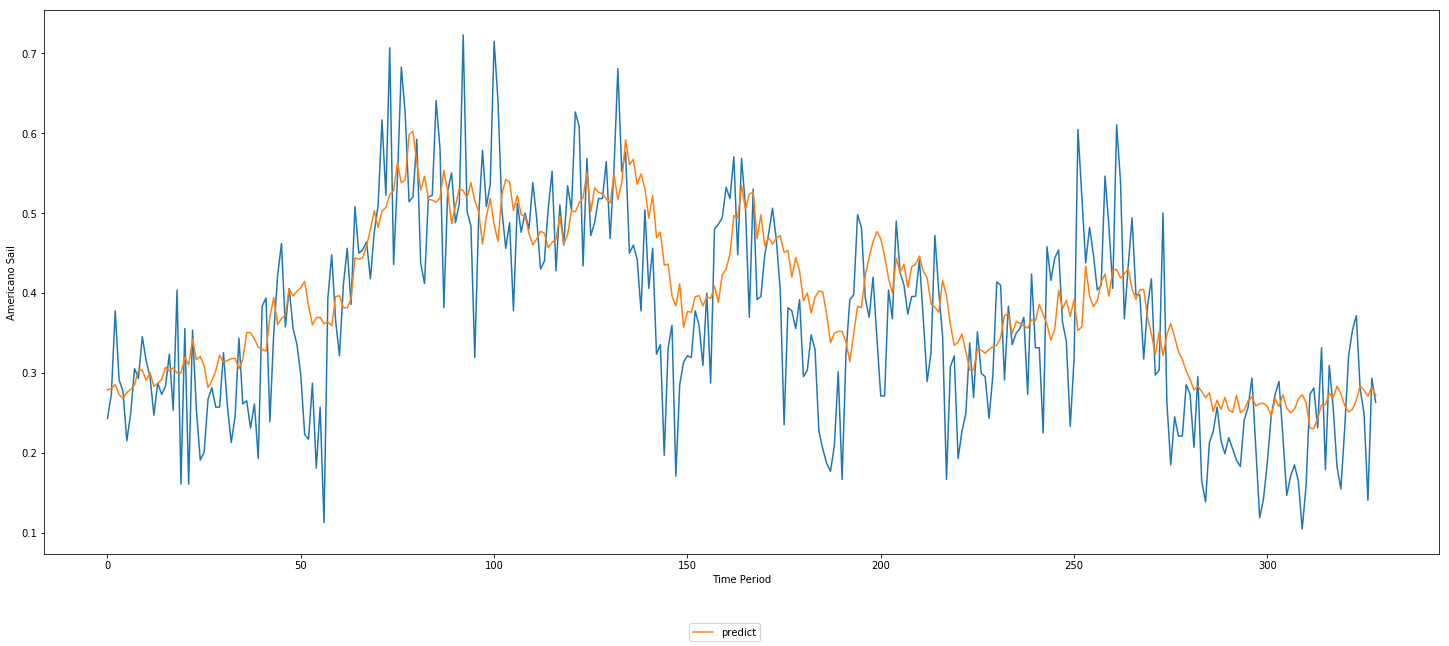

In [19]:
# Plot predictions
    ax = plt.figure(figsize = [25,10])
    plt.plot(testY[:,1])
    plt.plot(test_predict[:,1], label='predict')
    plt.xlabel("Time Period")
    plt.ylabel("Americano Sail")
    ax.legend(loc = 8)
    plt.show()

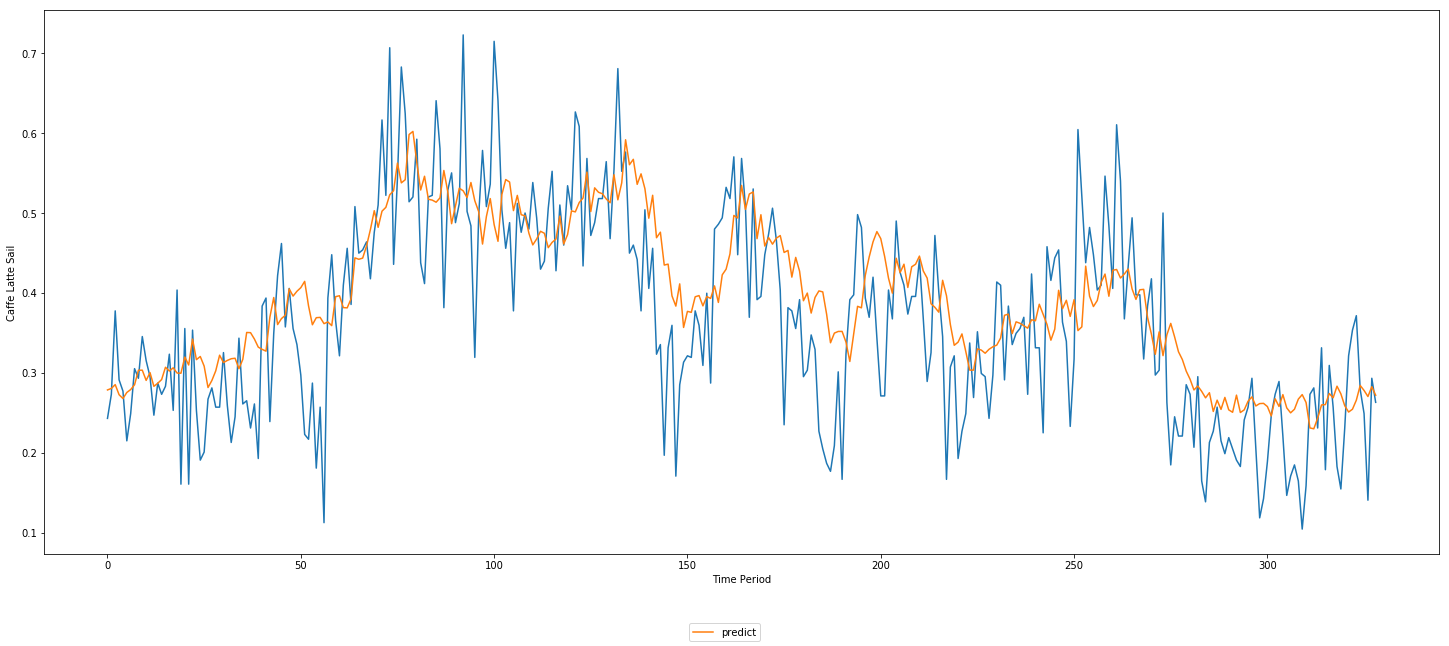

In [20]:
# Plot predictions
    ax2 = plt.figure(figsize = [25,10])
    plt.plot(testY[:,1])
    plt.plot(test_predict[:,1], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("Caffe Latte Sail")
    ax2.legend(loc = 8)
    plt.show()

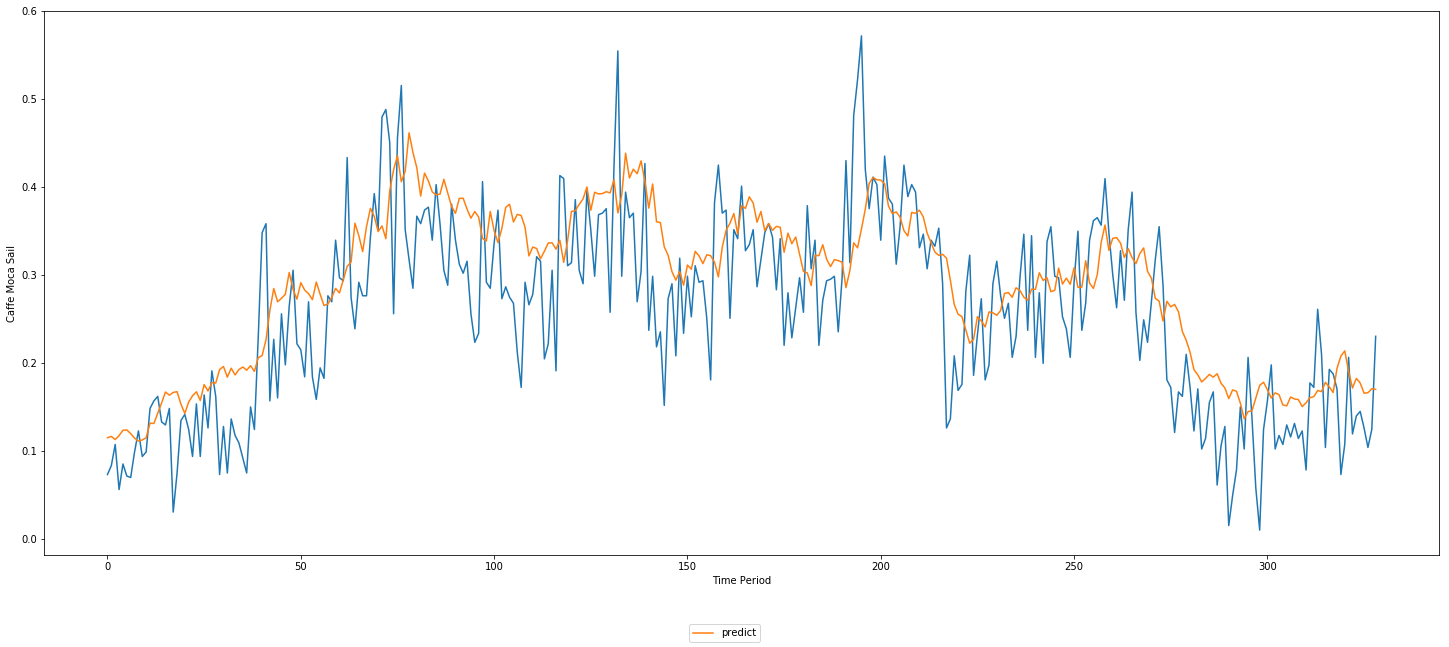

In [21]:
# Plot predictions
    ax3 = plt.figure(figsize = [25,10])
    plt.plot(testY[:,2])
    plt.plot(test_predict[:,2], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("Caffe Moca Sail")
    ax3.legend(loc = 8)    
    plt.show()

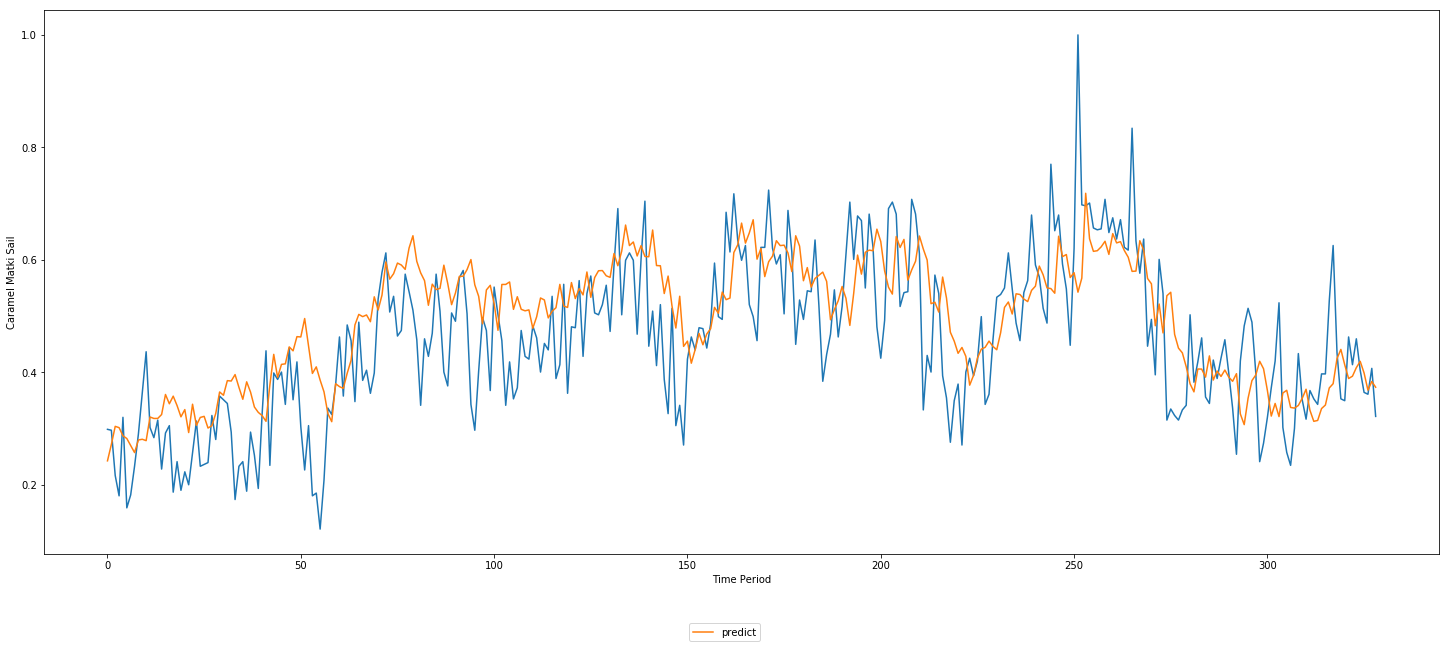

In [22]:
# Plot predictions
    ax4 = plt.figure(figsize = [25,10])
    plt.plot(testY[:,3])
    plt.plot(test_predict[:,3], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("Caramel Matki Sail")
    ax4.legend(loc = 8)
    plt.show()

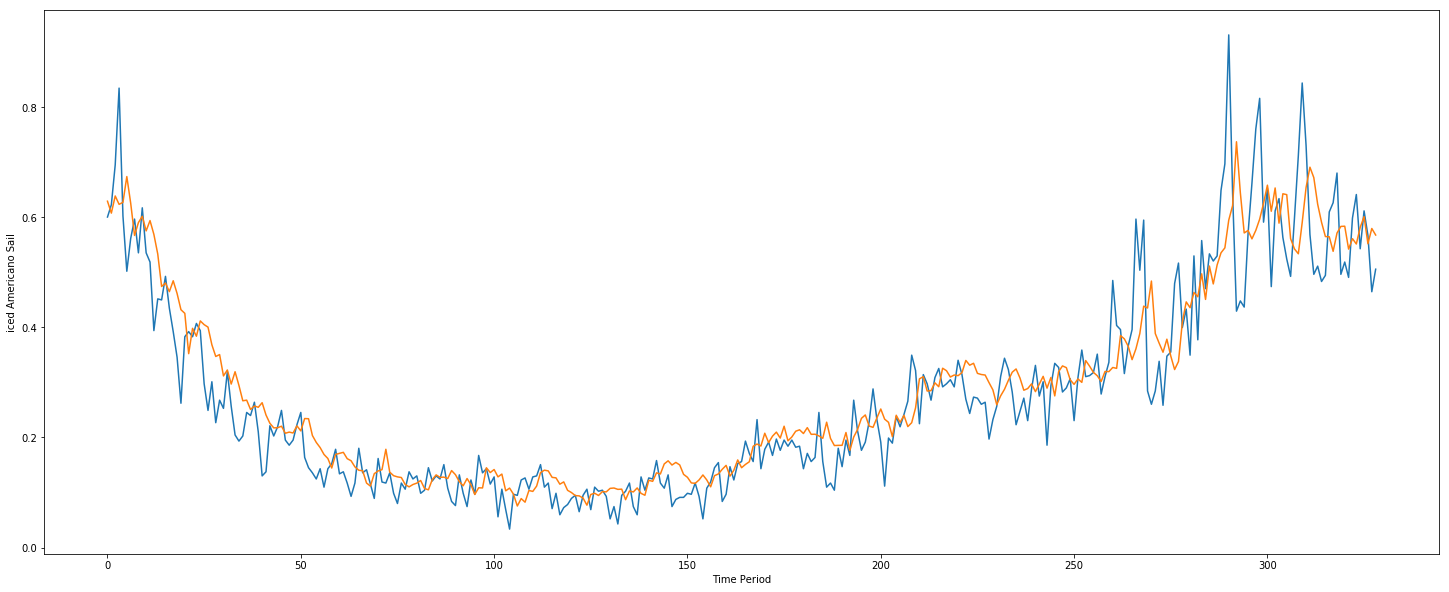

In [23]:
# Plot predictions
    plt.figure(figsize = [25,10])
    plt.plot(testY[:,4])
    plt.plot(test_predict[:,4], label = 'predict')
    plt.xlabel("Time Period")
    plt.ylabel("iced Americano Sail")
    ax.legend(loc = 8)
    plt.show()